In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML
import BasicTools as BT
import WaveTools as WT
import PlotTools as PT
import FFTTools as FFTT
import OperatorTools as OT
import GridTransferTools as GTT
import TestTools as TT
import SolverTools as ST

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In this cell, you initialize all your values.

In [ ]:
nh = 64
refRatio = 2
sigma = 0.1
mu = 0.5
c = 1.
nt = 80
CFL = 1.

Here, I'm making the grid, the waves, and the nullspace matrix. (Ignore the outputs from the nullspace function. I'm too nervous to get rid of my print statements yet. There's nothing to see here.)

In [ ]:
finehalf = list(np.arange(int(nh / refRatio)))
omega = BT.Grid(nh)
omegaFine = omega
wavesFine = WT.MakeWaves(omega)
omega.AddPatch(refRatio, finehalf)
nh_max = omega.nh_max
degFreed = omega.degFreed
waves = WT.MakeWaves(omega)
nullspace = OT.FindNullspace(omega, waves)
wavesMod = waves @ nullspace

# print(waves)
# print(waves[:, 0])
# print(waves[:, ::-1][:, 0])
# print((np.pi / 2) * nullspace @ waves[:, ::-1][:, 0])

Here's some math. It's sorta dicey and experimental.

In [ ]:
t, nt = ST.CalcTime(omega, CFL, c, nt = nt)
func = np.zeros(omega.degFreed, float) # TT.Gauss(omega, sigma, mu)
func[8:30] = 1 # 30, 19
# print(np.shape(func[8:19]))
# print(np.shape(wavesMod))
# print(np.shape(func))
FCoefs = FFTT.FourierCoefs(omega, wavesMod, func)
EulerCoefs = ST.ForwardEuler(omega, wavesMod, func, nt, c, CFL, ST.Upwind)
propFCoefs = FFTT.PropogateFCoefs(omega, FCoefs, c, t, nullspace = nullspace)
allCoefs = PT.Load(FCoefs, EulerCoefs)# propFCoefs, 

In [ ]:
FCoefs0 = np.zeros(degFreed, float) # FFTT.FourierCoefs(omega, wavesMod, func)
FCoefs0[::-1][0] = 1
# FCoefs = FCoefs @ nullspace
# print(FCoefs)
func0 = wavesMod @ FCoefs0
func = func0 # * (1 - ((np.pi / 2) * waves[:, ::-1][:, 0]))
FCoefs = FFTT.FourierCoefs(omega, wavesMod, func)
EulerCoefs = ST.ForwardEuler(omega, wavesMod, func, nt, c, CFL, ST.Upwind)
propFCoefs = FFTT.PropogateFCoefs(omega, FCoefs, c, t, nullspace = nullspace)
# allCoefs = PT.Load(FCoefs, propFCoefs, EulerCoefs)
propWaves = FFTT.PropWaves(omega, waves, c, t)

propFunc0 = (propWaves @ nullspace @ FCoefs)
oneVals = np.ones(degFreed, float)
oneVals[nh:] = 0
oneVals = (np.pi / 4 ) * oneVals
otherFunc = propFunc0 * (np.pi / 2) * abs(propWaves[:, ::-1][:, 0])
propFunc = propFunc0 - otherFunc
otherCoefs = FFTT.FourierCoefs(omega, propWaves @ nullspace, otherFunc)
propFCoefs2 = FFTT.FourierCoefs(omega, propWaves @ nullspace, propFunc)

propNull = OT.FindNullspace(omega, propWaves, shift = True)
PT.PlotMixedWave(omega, waves, nullspace @ allCoefs, rescale = 6, labels = [r'$u_{0} (x)$', r'Euler $u_{0} (x - c t)$'], dpi = 300, yGrid = True)



Here is the plot for the initial nullspace wave function.

In [ ]:
PT.PlotMixedWave(omega, waves, nullspace @ FCoefs, rescale = [6, 10])#, saveName = 'probInit', dpi = 300, labels = [r'$u_{0} (x)$'])


Here it is propagated forward using the "old" method (which, recall, doesn't work as well.)

In [ ]:
PT.PlotMixedWave(omega, waves, nullspace @ propFCoefs, rescale = [6, 10])#, saveName = 'probOld', dpi = 300, labels = [r'$u_{0} (x - c t)$'])


Here it is with the "new" method, which the square wave tests showed works better in the coarse region and some of the fine region.

In [ ]:
PT.PlotMixedWave(omega, propWaves, nullspace @ FCoefs, rescale = [6, 10], ct = c * t)#, saveName = 'probNew', dpi = 300, labels = [r'$u_{0} (x - c t)$'])


Here is my idea for forcing the solution to work in the fine region. Basically, I'm gonna subtract off the nonzero portion of the fine grid solution while leaving the coarse part alone, and then I'm gonna throw that new solution into a Fourier transform and see what coefficients it gives me. The only way I could see this possibly working would be if it doesn't preserve the analytic solution in the background, only the cell-average solution. (Also, I think I'd need to leave the portion of the fine solution which appears working okay, which I suspect to be the portion which was already somewhere in the fine region prior to propagation, alone.) But anyway, here's the wave I'm subtracting off.

In [ ]:
PT.PlotMixedWave(omega, propWaves, nullspace @ otherCoefs, rescale = [6, 10], ct = c * t)


And here's the new wave, in which the wave in the previous cell is subtracted off of the wave found using the new method.

In [ ]:
PT.PlotMixedWave(omega, propWaves, nullspace @ propFCoefs2, rescale = [6, 10], ct = c * t)#, saveName = 'probNew', dpi = 300, labels = [r'$u_{0} (x - c t)$'])


As janky as this idea is, it appears to be giving surprisingly decent cell-average values in the coarse region. Here is a comparison between the values in the wave in cell 8 (the "new" method) and the wave from this last proposed method (cell 10.) Notice that the coarse region (the last eight values) seems relatively unaffected (on the order of $10^{-9}$ - $10^{-10}$ difference.) Again, it's not a great idea. But it's an idea.

In [ ]:
A = propWaves @ nullspace @ FCoefs
B = propWaves @ nullspace @ propFCoefs2
print(A)
print(B)
print(A - B)

Everything after this is either commented out (as you can see) or my progress so far on the Midpoint Method. If you have comments on that, they're definitely welcome.

In [ ]:
# ks, error = TT.CalcError(omega, propFCoefs, EulerCoefs, errorType = 'relative')
# fig, ax = plt.subplots(figsize = [20, 6])
# plt.plot(ks, error)
# # plt.plot(ks, EulerCoefs)
# # plt.plot(ks, propFCoefs)
# plt.title('Error for CFL = ' + str(CFL))
# plt.xlabel('Wavenumber')
# plt.ylabel('Error')
# plt.show()

In [ ]:
# norms, CFLs = TT.NormVersusCFL(ST.ForwardEuler, omega, waves, gauss, c, CFL, nt, normType = 'L1', errorType = 'absolute')
# plt.figure()
# plt.plot(CFLs, norms)
# plt.title('Error versus CFL Condition for Forward Euler')
# plt.xlabel('CFL')
# plt.ylabel('Error')
# plt.show()


In [ ]:
# A = np.arange(20)
# B = A[::2][1:]
# C = A[1::2][:-1]
# print(A)
# print(B)
# print(C)
# print(propFCoefs)

In [ ]:
# ampKs, ampError = TT.AmpError(omega, EulerCoefs, propFCoefs)

In [ ]:
# ks, error = TT.CalcError(omega, propFCoefs, EulerCoefs, errorType = 'relative')
# fig, ax = plt.subplots(figsize = [20, 6])
# plt.plot(ampKs, ampError)
# plt.title('Amplitude Error for CFL = ' + str(CFL))
# plt.xlabel('Wavenumber')
# plt.ylabel('Error')
# plt.show()

In [ ]:
# deltaCoefs = np.ones(nh, float)
# PT.PlotMixedWave(omega, waves, deltaCoefs, rescale = [4, 6])

In [ ]:
# deltaCoefs[1::2] = 0
# PT.PlotMixedWave(omega, waves, deltaCoefs, rescale = [4, 6])

In [ ]:
# deltaCoefs = np.ones(nh, float)
# deltaCoefs[::2] = 0
# PT.PlotMixedWave(omega, waves, deltaCoefs, rescale = [4, 6])

In [ ]:
# Cosine = lambda k: np.cos(2. * np.pi * k)
# Sine = lambda k: np.sin(2. * np.pi * k)
# RotMat = lambda k: np.asarray([Cosine(k), -Sine(k), Sine(k), Cosine(k)]).reshape(2, 2)
# print(RotMat(0.125))

In [ ]:
# def ExplicitMidpoint(omega, waves, u0, nt, const, CFL, periodic = True):
#     degFreed = omega.degFreed
#     x = omega.xCell
#     dx = omega.dx
#     dx_0 = 1 - x[::-1][0] + x[0]
#     dt = CFL * dx / const
#     dt_0 = CFL * dx_0 / const
#     t = nt * dt[0]
#     u = u0.copy()
    
    
# #     for n in range(nt):
# #         u_f = u[::-1][0]
# #         u[1:] = u[1:] - (const * (dt / dx) * (u[1:] - u[:-1]))
# #         if (periodic == True):
# #             u[0] = u[0] - (const * (dt_0 / dx_0) * (u[0] - u_f))
    
#     h = (b - a) / n;
# halfh = h / 2;
# y(1,:) = ya;
# t(1) = a;
# for i = 1 : n
#     t(i+1) = t(i) + h;
#     z = y(i,:) + halfh * f(t(i),y(i,:));
#     y(i+1,:) = y(i,:) + h * f(t(i)+halfh,z);
    
    
#     uCoefs = LA.inv(waves) @ u
#     return uCoefs, t

In [4]:
nh = 128
refRatio = 2
omega = BT.Grid(nh)
waves = WT.MakeWaves(omega)
nt = 120
CFL = 0.5
c = 1
t, nt = ST.CalcTime(omega, CFL, c, nt = nt)
print(t)

0.46875


k1 = 3.2131520595867187
k2 = 3.231551182529074
k3 = 3.231551182529074
k4 = 3.250065803527832
1.862384289507654 does not need to equal 1.8623842895030975.
3.250065803527832
(128,)
Are you *sure* your labels are ordered correctly?


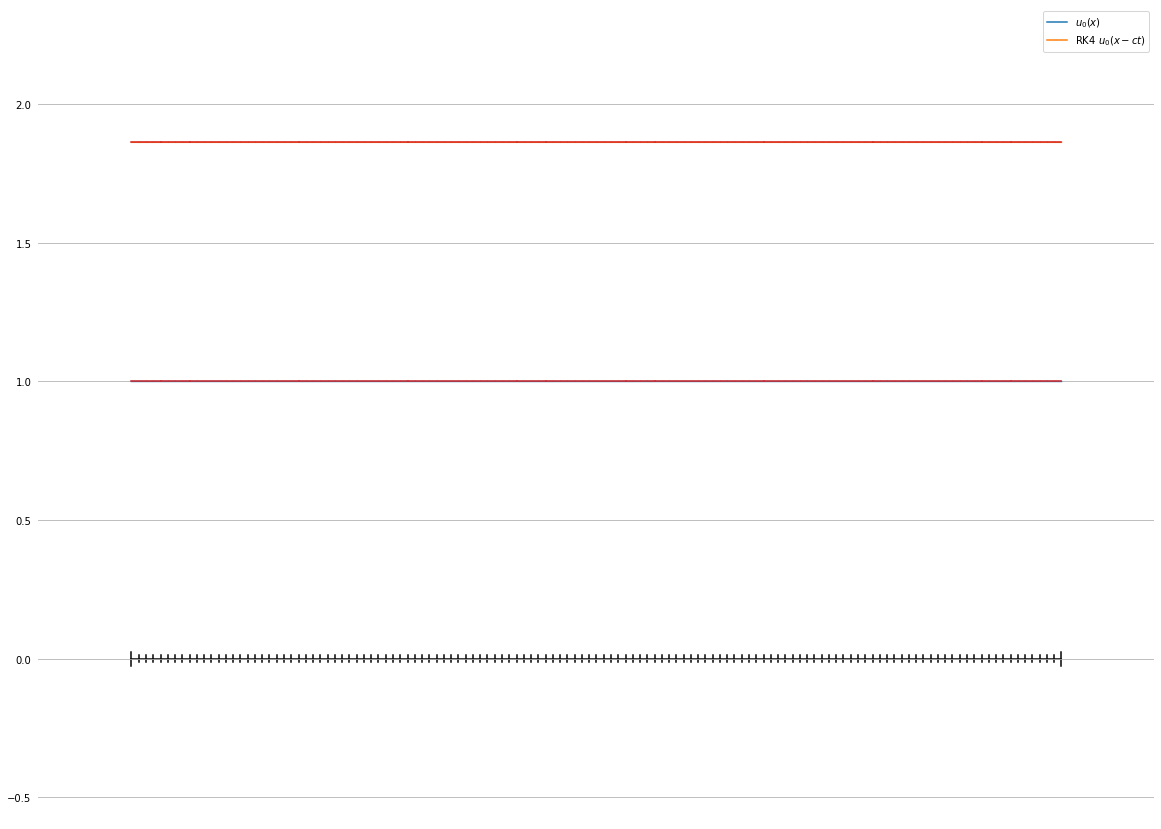

In [9]:
# func = np.zeros(omega.degFreed, float) # TT.Gauss(omega, sigma, mu)
# func[8:30] = 1
# print(np.shape(wavesMod))
# print(np.shape(func))
FCoefs = np.zeros(nh, float) # FFTT.FourierCoefs(omega, waves, func)
FCoefs[0] = 1
func = waves @ FCoefs
# FCoefs[::2] = 
order = 5
EulerCoefs = ST.RK4(omega, waves, func, nt, c, CFL, ST.TimePoly, order = order)
print(ST.TimePoly(omega, t, func, c, order))
print(np.shape(EulerCoefs))
# propFCoefs = FFTT.PropogateFCoefs(omega, FCoefs, c, t)
allCoefs = PT.Load(FCoefs, EulerCoefs)
PT.PlotMixedWave(omega, waves, allCoefs, rescale = [4, 6], labels = [r'$u_{0} (x)$', r'RK4 $u_{0} (x - c t)$'], yGrid = True)# , save = True)



In [6]:
func = np.zeros(omega.degFreed, float) # TT.Gauss(omega, sigma, mu)
func[8:30] = 1
print(np.shape(wavesMod))
print(np.shape(func))
FCoefs = FFTT.FourierCoefs(omega, waves, func)
# FCoefs[::2] = 0
EulerCoefs = ST.RK4(omega, waves, func, nt, c, CFL, ST.Upwind)
print(np.shape(EulerCoefs))
# propFCoefs = FFTT.PropogateFCoefs(omega, FCoefs, c, t)
allCoefs = PT.Load(FCoefs, EulerCoefs)
PT.PlotMixedWave(omega, waves, allCoefs, rescale = [4, 6], labels = [r'$u_{0} (x)$', r'Midpoint Method $u_{0} (x - c t)$'])#, save = True)


NameError: name 'wavesMod' is not defined